In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 30

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRAYSCALE = True

In [3]:
DEVICE

device(type='cuda')

In [4]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [14]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    print(model)
    return model



In [15]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
cost_epoch = np.zeros(NUM_EPOCHS)
acc_epoch = np.zeros(NUM_EPOCHS)
acc_epoch_test = np.zeros(NUM_EPOCHS)
# Training
for epoch in range(NUM_EPOCHS):
    #print('\nEpoch: %d' % epoch+1)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
          ### FORWARD AND BACK PROP
        outputs, probs = model(inputs)
        
        
        # optimizer.zero_grad()
        # outputs = model(inputs)
        cost = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

   ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        cost_epoch[epoch] = cost
        
    model.eval()

    with torch.set_grad_enabled(False): # save memory during inference
        acc_epoch[epoch] = compute_accuracy(model, train_loader, device=DEVICE)
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,  acc_epoch[epoch]
              ))
        
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
      acc_epoch_test[epoch] = compute_accuracy(model, test_loader, device=DEVICE)
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))



Epoch: 001/030 | Batch 0000/0469 | Cost: 2.6379
Epoch: 001/030 | Batch 0050/0469 | Cost: 0.1759
Epoch: 001/030 | Batch 0100/0469 | Cost: 0.0538
Epoch: 001/030 | Batch 0150/0469 | Cost: 0.0858
Epoch: 001/030 | Batch 0200/0469 | Cost: 0.1082
Epoch: 001/030 | Batch 0250/0469 | Cost: 0.1303
Epoch: 001/030 | Batch 0300/0469 | Cost: 0.0314
Epoch: 001/030 | Batch 0350/0469 | Cost: 0.1413
Epoch: 001/030 | Batch 0400/0469 | Cost: 0.1062
Epoch: 001/030 | Batch 0450/0469 | Cost: 0.0334
Epoch: 001/030 | Train: 97.623%
Time elapsed: 0.82 min
Epoch: 002/030 | Batch 0000/0469 | Cost: 0.0412
Epoch: 002/030 | Batch 0050/0469 | Cost: 0.0289
Epoch: 002/030 | Batch 0100/0469 | Cost: 0.0381
Epoch: 002/030 | Batch 0150/0469 | Cost: 0.0572
Epoch: 002/030 | Batch 0200/0469 | Cost: 0.0659
Epoch: 002/030 | Batch 0250/0469 | Cost: 0.0231
Epoch: 002/030 | Batch 0300/0469 | Cost: 0.0066
Epoch: 002/030 | Batch 0350/0469 | Cost: 0.0540
Epoch: 002/030 | Batch 0400/0469 | Cost: 0.0488
Epoch: 002/030 | Batch 0450/0469 

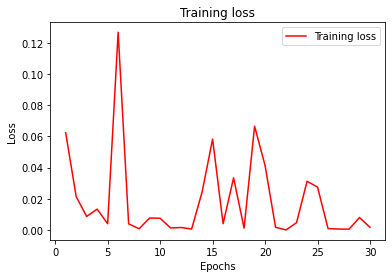

In [9]:
plt.plot(range(1, NUM_EPOCHS+1), cost_epoch, 'r', label='Training loss')
# plt.plot(NUM_EPOCHS, acc_epoch, 'b', label='Accuracy')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


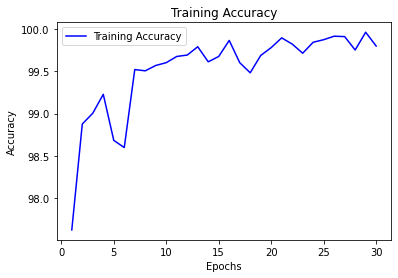

In [10]:

plt.plot(range(1,NUM_EPOCHS+1), acc_epoch, 'b', label='Training Accuracy')
# plt.plot(NUM_EPOCHS, acc_epoch, 'b', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 99.13%


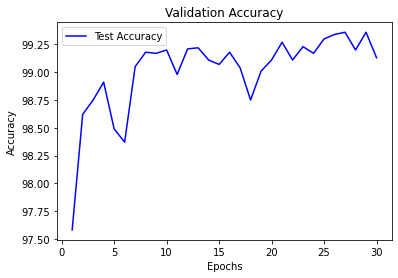

In [12]:
plt.plot(range(1,NUM_EPOCHS+1), acc_epoch_test, 'b', label='Test Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ValueError: ignored

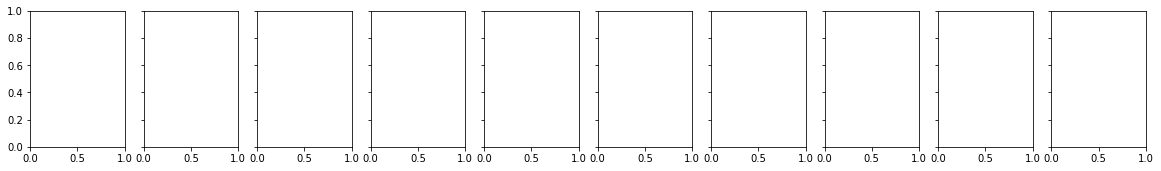

In [44]:

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

#features = np.random()

logits, labels = model(features.to(device))
_, predicted_labels = torch.max(logits, 1)


fig, axes = plt.subplots(nrows=1, ncols=10, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

for i in range(10):    
  nhwc_img = np.transpose(features[i], axes=(1, 2, 0))
  nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
  axes[i].set_title("Prediction: {}".format(predicted_labels[i]))
  axes[i].imshow(nhw_img, cmap='Greys');



In [ ]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

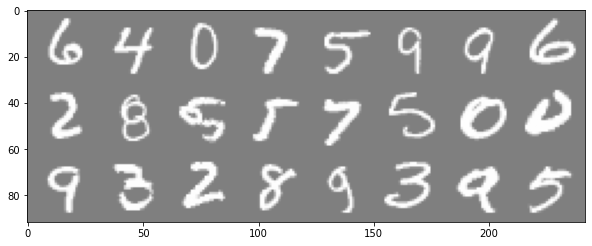

In [45]:
import torchvision

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.figure(figsize=[10, 10])
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=[10, 10])
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[:24])

# show images
matplotlib_imshow(img_grid)

In [46]:
from torch.utils.tensorboard import SummaryWriter
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import torchvision

writer = SummaryWriter('MNIST')

In [47]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[:48])

# show images
#matplotlib_imshow(img_grid)

writer.add_image('MNIST', img_grid)

In [49]:
#%load_ext tensorboard
%tensorboard --logdir=runs


Reusing TensorBoard on port 6006 (pid 571), started 0:05:36 ago. (Use '!kill 571' to kill it.)

<IPython.core.display.Javascript object>

In [31]:

!pip install tensorboardcolab

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3859 sha256=142f1000e9d98bf8ebd78196b3840d88fb0fe53d6044d86b4bf12269937cee1e
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built tensorboardcolab
